https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm

In [1]:
import os
import platform

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
import gc

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(platform.system())
if platform.system() == 'Darwin':
    path = "/Volumes/Buffalo-SSD/Kaggle_Datasets/Kaggle_IEEE_FraudDetection/input/"
elif platform.system() == 'windows':
    path = "/Volumes/Buffalo-SSD/SIGNATE_Datasets/SIGNATE_TakedaAI/input/"

Darwin


In [3]:
%%time
os.listdir(path)

CPU times: user 214 µs, sys: 196 µs, total: 410 µs
Wall time: 300 µs


['test_transaction.csv',
 '._test_transaction.csv',
 'train_identity.csv',
 '._train_identity.csv',
 'test_identity.csv',
 '._test_identity.csv',
 'sample_submission.csv',
 '._sample_submission.csv',
 'train_transaction.csv',
 '._train_transaction.csv',
 'train_feature1.csv',
 'test_feature1.csv',
 'train_upsampled.csv',
 'val_data.csv',
 'train_downsampled.csv',
 'train_upsampled_all.csv',
 'train_downsampled_all.csv']

In [4]:
train = pd.read_csv(f'{path}train_downsampled_all.csv')

In [5]:
test = pd.read_csv(f'{path}test_feature1.csv')

In [6]:
train.shape

(41326, 339)

In [7]:
test.shape

(506691, 337)

In [8]:
X = train.sort_values('TransactionDT').drop(['Unnamed: 0', 'TransactionID', 'isFraud', 'TransactionDT'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

X_test = test.drop(['TransactionID', 'TransactionDT'], axis=1)

gc.collect()

11

In [9]:
del(train, test)

In [10]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,card6_count_full,id_36_count_full,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,...,267648,819269,446307,450258,517251,449555,6,6,6,6
1,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,...,824959,819269,446307,450258,517251,449555,9,0,6,6
2,15.0,1,2803,100.0,150.0,4,226.0,2,337.0,87.0,...,824959,267353,82170,13423,6447,134066,7,0,6,6
3,117.0,4,13085,417.0,150.0,4,195.0,2,330.0,87.0,...,824959,819269,446307,450258,517251,449555,4,0,6,6
4,39.5,4,9281,555.0,150.0,4,195.0,2,472.0,87.0,...,824959,819269,446307,450258,517251,449555,4,0,6,6


In [11]:
X.shape

(41326, 335)

In [12]:
X_test.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,card6_count_full,id_36_count_full,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,31.95,4,10409,111.0,150.0,4,226.0,2,170.0,87.0,...,824959,819269,364784,370066,436020,369714,4,0,6,6
1,49.00,4,4272,111.0,150.0,4,226.0,2,299.0,87.0,...,824959,819269,364784,370066,436020,369714,0,0,6,6
2,171.00,4,4476,574.0,150.0,4,226.0,2,472.0,87.0,...,824959,819269,364784,370066,436020,369714,5,0,6,6
3,285.00,4,10989,360.0,150.0,4,166.0,2,205.0,87.0,...,824959,819269,364784,370066,436020,369714,4,0,6,6
4,67.94,4,18018,452.0,150.0,2,117.0,2,264.0,87.0,...,824959,819269,364784,370066,436020,369714,4,0,6,6


In [13]:
X_test.shape

(506691, 335)

In [14]:
from sklearn.model_selection import KFold
import lightgbm as lgb

In [15]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

In [16]:
%%time

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.939001	valid_1's auc: 0.875945
[400]	training's auc: 0.958979	valid_1's auc: 0.885369
[600]	training's auc: 0.974903	valid_1's auc: 0.893635
[800]	training's auc: 0.985377	valid_1's auc: 0.898799
[1000]	training's auc: 0.991813	valid_1's auc: 0.901634
[1200]	training's auc: 0.995579	valid_1's auc: 0.903069
[1400]	training's auc: 0.997678	valid_1's auc: 0.903755
[1600]	training's auc: 0.998827	valid_1's auc: 0.904117
[1800]	training's auc: 0.999441	valid_1's auc: 0.904233
[2000]	training's auc: 0.999745	valid_1's auc: 0.90428
[2200]	training's auc: 0.999885	valid_1's auc: 0.904343
[2400]	training's auc: 0.99995	valid_1's auc: 0.904241
[2600]	training's auc: 0.999979	valid_1's auc: 0.904209
Early stopping, best iteration is:
[2174]	training's auc: 0.999872	valid_1's auc: 0.904372
Fold 1 | AUC: 0.9043724871997655
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.9360

In [17]:
sub = pd.read_csv(f'{path}sample_submission.csv')

In [18]:
sub['isFraud'] = y_preds
sub.to_csv("feature1_downsampled.csv", index=False)

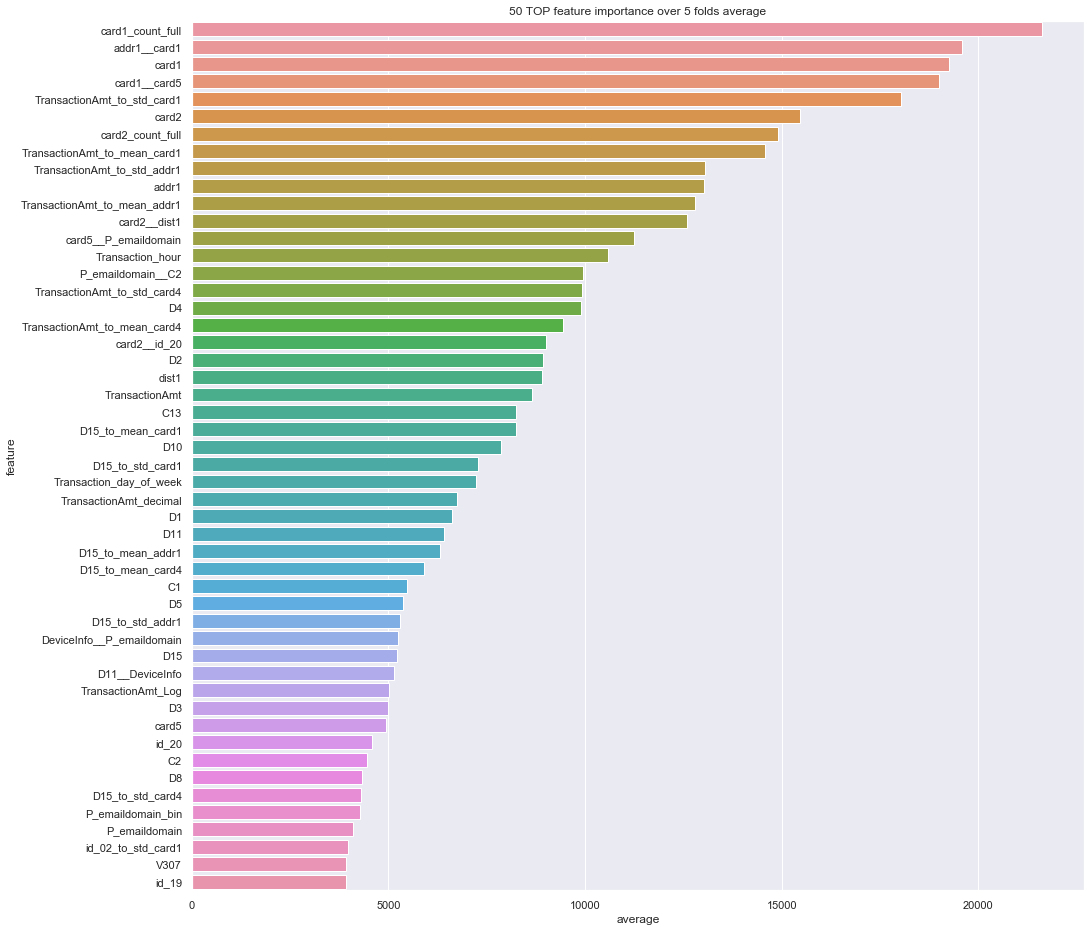

In [19]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature1_sampled_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [20]:
feature_importances.sort_values(by='average', ascending=False).head(50)

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
320,card1_count_full,15841,27152,20005,21851,23204,21610.6
319,addr1__card1,14042,24201,18738,19747,21223,19590.2
2,card1,14533,24382,17442,19287,20568,19242.4
316,card1__card5,14513,23947,17422,19026,20093,19000.2
289,TransactionAmt_to_std_card1,12671,23619,16476,18137,19236,18027.8
3,card2,11679,19493,14238,15673,16172,15451.0
321,card2_count_full,11470,18994,13729,14432,15917,14908.4
288,TransactionAmt_to_mean_card1,10480,18369,13304,14893,15883,14585.8
293,TransactionAmt_to_std_addr1,9781,16445,11472,13617,13883,13039.6
8,addr1,9309,16345,12242,13056,14152,13020.8
